In [5]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown (see cell below)
# or pip install gdown install --upgrade --no-cache-dir gdown

# cd /root
# python
# import gdown
# id = "1-44s78x-_XgSryME7_uJU3Kv-Poe202a" LUCAS NIRS
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

# paperspace only
!pip install spanda

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from pathlib import Path
from fastai.vision.all import *
from fastai.data.all import *
from tqdm import tqdm


from spanda.data.transforms import (SpectraBlock, AnalytesBlock, SpectraTfm, 
                                    AnalytesTfm, SNVTfm, RandWAvgTfm, NormalizeTfm, LogTfm)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [8]:
# Only samples with spectra
#path = Path('../../_data/lucas-nirs')
path = Path('/root/lucas-nirs')
paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]; print(f'n samples: {len(paths)}')

100%|██████████| 21859/21859 [00:00<00:00, 48819.93it/s]

n samples: 21782


In [10]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [12]:
# Only strictly positive measurements (
paths = [p for p in paths if AnalytesTfm(analytes=['K'])(get_target(p)) != 0] 
print(f'n samples: {len(paths)}')


 41%|████      | 8925/21782 [00:23<00:17, 754.19it/s]

n samples: 21779


In [ ]:
# Stats

## Spectra
#Xs = []
#n = 0
#for p in paths:
#    Xs.append(SpectraTfm()(get_target(p)))
#    n += 1 
#    if n > 1000: break
#print(f'X mean: {torch.mean(torch.concat(Xs))}, X Std: {torch.std(torch.concat(Xs))}');

In [ ]:
ys = []
n = 0
for p in paths:
    ys.append(AnalytesTfm(analytes=['K'])(get_target(p)))
    n += 1 
    if n > 1000: break

In [ ]:
torch.concat(ys).min()

Analytes(1.3000)

In [ ]:
torch.concat(ys).max()

Analytes(10030.9004)

In [ ]:
torch.concat(ys).mean()

Analytes(211.0901)

(array([  1.,   1.,   2.,   0.,   1.,  15.,  39.,  66., 107., 163., 206.,
        180., 124.,  67.,  22.,   3.,   3.,   0.,   0.,   1.]),
 array([0.11394334, 0.30831316, 0.50268298, 0.69705284, 0.89142263,
        1.08579254, 1.28016233, 1.47453213, 1.66890192, 1.86327183,
        2.05764151, 2.25201154, 2.44638133, 2.64075112, 2.83512092,
        3.02949071, 3.2238605 , 3.41823053, 3.61260033, 3.80697012,
        4.00133991]),
 <BarContainer object of 20 artists>)

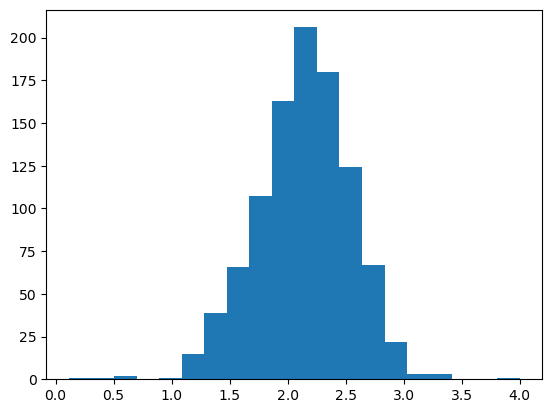

In [ ]:
import matplotlib.pyplot as plt

plt.hist(torch.log10(torch.concat(ys)), bins=20)
#plt.xscale('log') 

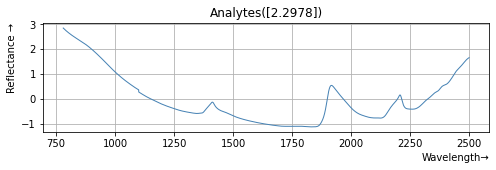

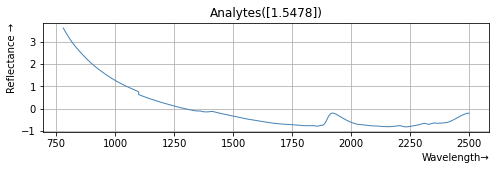

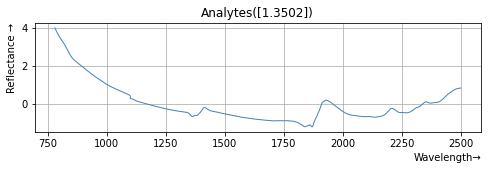

In [13]:
n_smp = None # None for all

#get_spectra = lambda o: L(fname for fname in o.ls() if re.match('\d+_\d', fname.name))
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=['K'])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(),
                   item_tfms=[RandWAvgTfm(), SNVTfm(),
                              LogTfm()])

dls = dblock.dataloaders(paths[:n_smp], bs=3)
dls.show_batch()

In [20]:
# Create Learner
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score()).to_fp16()

SuggestedLRs(valley=0.004365158267319202)

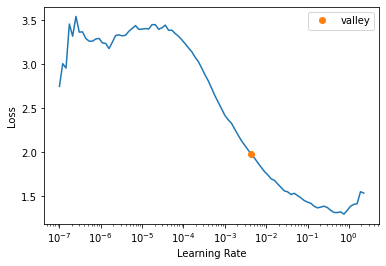

In [18]:
learn.lr_find()

In [21]:
learn.fit_one_cycle(40, 3e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.141488,0.136409,0.106276,02:25
1,0.109295,0.136339,0.106734,02:24
2,0.146336,0.126684,0.169993,02:24
3,0.116739,0.121249,0.205598,02:23
4,0.153237,0.127999,0.161379,02:27
5,0.111631,0.122320,0.198580,02:25
6,0.111629,0.156234,-0.023614,02:27
7,0.131285,0.115474,0.243438,02:27
8,0.140238,0.117467,0.230381,02:27
9,0.123752,0.126940,0.168312,02:27


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [22]:
learn.save('xresnet18-kex-nirs-lucas-40-epochs-lr-3e3-r2-0-61')

Path('models/xresnet18-kex-nirs-lucas-40-epochs-lr-3e3-r2-.pth')